## Setup

Just basic imports. Most important for now is the randomization seed.
Also, define a function that can label the bins in the histogram with their value.

In [1]:
from configs import merged_cycle_data_file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.model_selection import train_test_split

rnd_seed = 42069
np.random.seed(rnd_seed)
random.seed(rnd_seed)
fig_size = (16, 10)

one_day_secs = 24 * 60 * 60 # 1 day in seconds
def print_hist_labels(hist):
    for p in hist.patches:
        y_value = p.get_height()
        x_value = p.get_x() + p.get_width() / 2

        label = y_value
        hist.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, 10),             # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='top',                   # Vertically center label
            ha='center')

## Get the data
Pick a random sample from the dataset. Save this sample to a file to increase the speed.
If this file already exists, then just load it straight away.

In [2]:
# check if we have a cached file
import os
output = 'analysis.csv'
if not os.path.isfile(output):
    print(f'{output} file not found')
    p = 0.05  # 5% of the lines
    df = pd.read_csv(
        merged_cycle_data_file,
        index_col='Rental Id',
        parse_dates=['End Date', 'Start Date'],
        header=0,
        skiprows=lambda i: i>0 and random.random() > p)
    df.to_csv(output)
else:
    print(f'Found file {output}')
    df = pd.read_csv(
        output,
        index_col='Rental Id',
        parse_dates=['End Date', 'Start Date']
    )

Found file analysis.csv


/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Look at the bike shares data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2377757 entries, 50754227 to 47944013
Data columns (total 5 columns):
Duration           float64
End Date           datetime64[ns]
EndStation Id      float64
Start Date         datetime64[ns]
StartStation Id    int64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 108.8 MB


Drop rows with missing data

In [4]:
print('Old size:', len(df))
df = df.dropna()
print('New size:', len(df))

Old size: 2377757
New size: 2369507


In [5]:
df.head()

,Duration,End Date,EndStation Id,Start Date,StartStation Id
Rental Id,,,,,
50754227,1200.0,2016-10-01 00:20:00,272.0,2016-10-01 00:00:00,425
50754232,480.0,2016-10-01 00:11:00,780.0,2016-10-01 00:03:00,755
50754241,180.0,2016-10-01 00:11:00,78.0,2016-10-01 00:08:00,264
50754248,300.0,2016-10-01 00:14:00,400.0,2016-10-01 00:09:00,116
50754264,300.0,2016-10-01 00:20:00,606.0,2016-10-01 00:15:00,337


In [6]:
df.describe()

,Duration,EndStation Id,StartStation Id
count,2.369507e+06,2.369507e+06,2.369507e+06
mean,1.277110e+03,1.128346e+03,7.771705e+02
std,7.589262e+03,1.366008e+04,1.003652e+04
min,-3.120000e+03,1.000000e+00,1.000000e+00
25%,4.800000e+02,1.570000e+02,1.590000e+02
50%,8.400000e+02,3.210000e+02,3.250000e+02
75%,1.260000e+03,5.570000e+02,5.570000e+02
max,2.159880e+06,3.002490e+05,3.002490e+05


As we can see, we have ***negative*** values for duration.
Also, let's analyse the distribution.

Text(0.5, 1.0, 'Duration distribution')

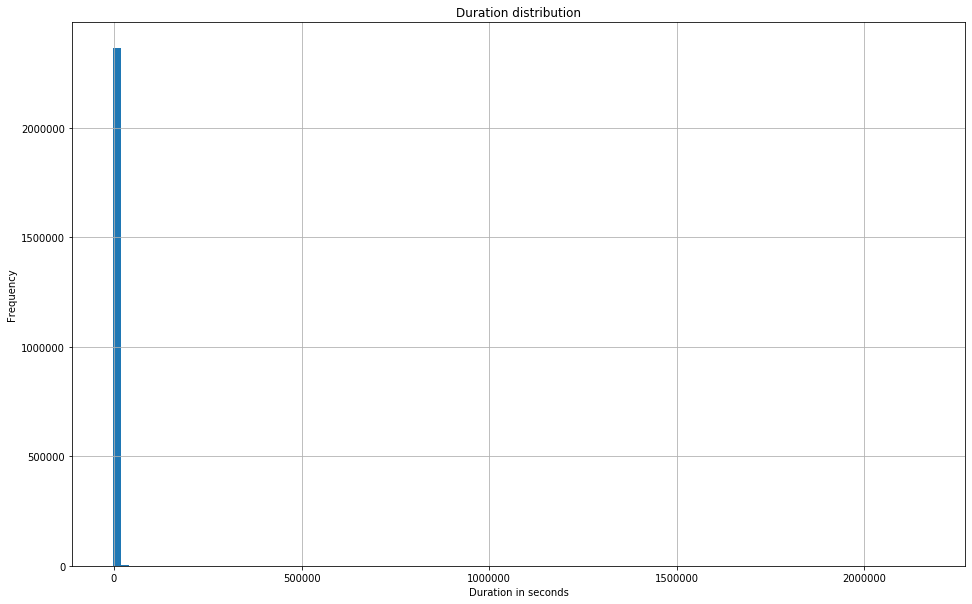

In [16]:
df['Duration'].hist(bins=100, figsize=fig_size)
plt.xlabel('Duration in seconds')
plt.ylabel('Frequency')
plt.title('Duration distribution')


It looks like we have some ***outliers***. Let's try and get rid of them because they will skew the dataset.

In [8]:
len(df[(df['Duration'] > one_day_secs) | (df['Duration'] < 0)])

817

There are rows where the `Duration` value does not match the difference between `End Date` and `Start Date`.

Also, there are rows where `Start Date` is after `End Date`.

In [7]:
diff = df['End Date'] - df['Start Date'] # compute the difference between the objects
seconds = diff.map(lambda x: x.total_seconds()) # map to seconds
df = df[(df['Duration'] == seconds) & (seconds >= 0)] # check if duration matches the result and if the result is positive

Visualize the distribution of the `Duration` in minutes, but only shows durations shorten than 2 hours.

Text(0.5, 1.0, 'Duration distribution')

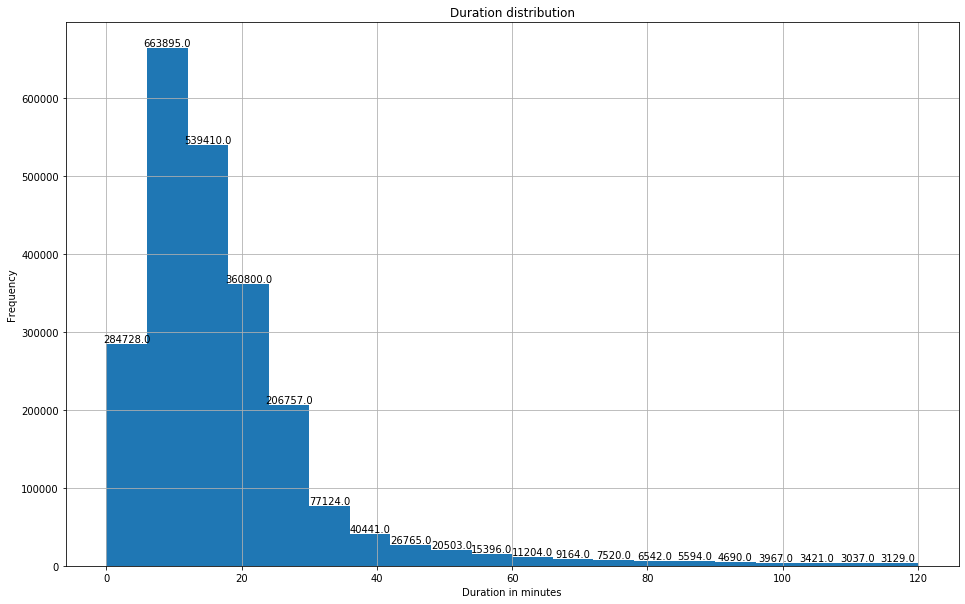

In [8]:
# leave only entries that are shorter than 2 hours and have valid duration
valid_df = df[(df['Duration'] >= 0) & (df['Duration'] <= 2 * 60 * 60)]
hist = valid_df['Duration'].map(lambda x: x / 60).hist(bins=20, figsize=fig_size)
print_hist_labels(hist)
df, valid_df = valid_df, None
plt.xlabel('Duration in minutes')
plt.ylabel('Frequency')
plt.title('Duration distribution')

We are mostly interested in the hour when the share happened, as the weather information is per hour.
Therefore, we should mention that we lose a bit of precision here by only extracting the hour.
The same could be said about the year, but this one might have less influence.

In [31]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df['month'] = df['Start Date'].apply(lambda t: t.month).map(lambda x: months[x-1]) # 1 is January, 12 is December
df['weekday'] = df['Start Date'].apply(lambda t: t.weekday()).map(lambda x: days[x]) # 0 is Monday, 6 is Sunday
df['hour'] = df['Start Date'].apply(lambda t: t.hour)

Text(0.5, 1.0, 'Hour Sample Distribution')

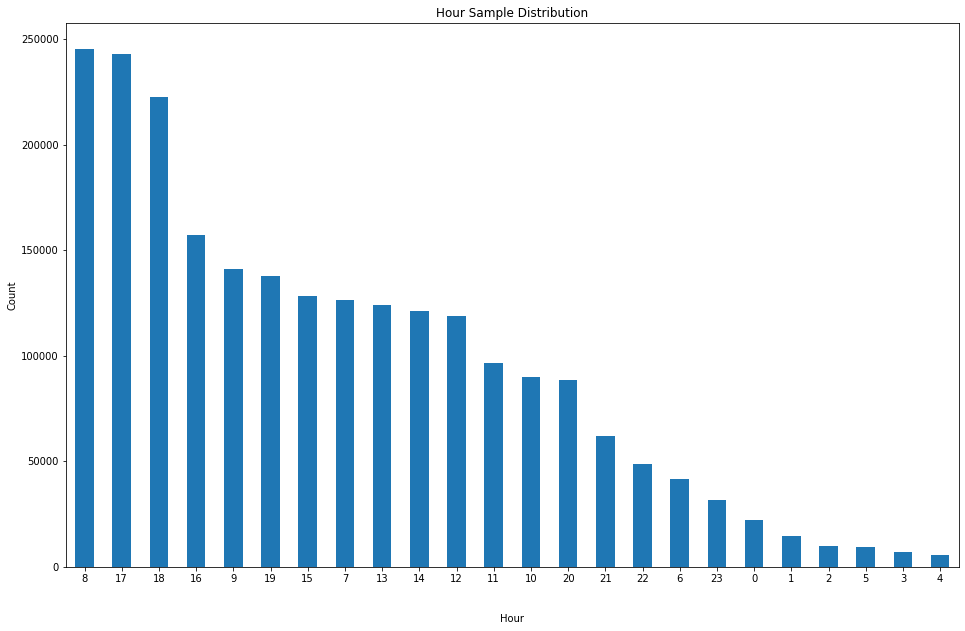

In [37]:
# how many shares per hour in total?
axes = df['hour'].value_counts().plot(kind='bar', figsize=fig_size)
axes.set_xlabel('Weekday', labelpad=30)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Hour Sample Distribution')

Most of the shares happen at 8 o'clock and at 17 o'clock. This could be related with people renting bikes to get to work or home from work.

Text(0.5, 1.0, 'Weekday Sample Distribution')

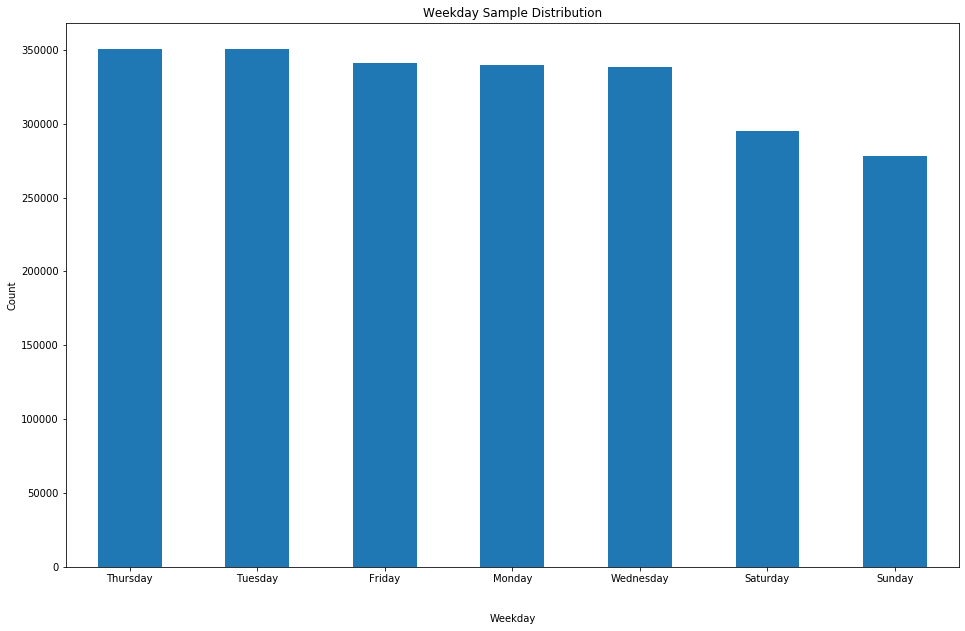

In [38]:
# how many shares per weekday in total?
axes = df['weekday'].value_counts().plot(kind='bar', figsize=fig_size)
axes.set_xlabel('Weekday', labelpad=30)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Weekday Sample Distribution')

Text(0.5, 1.0, 'Month Sample Distribution')

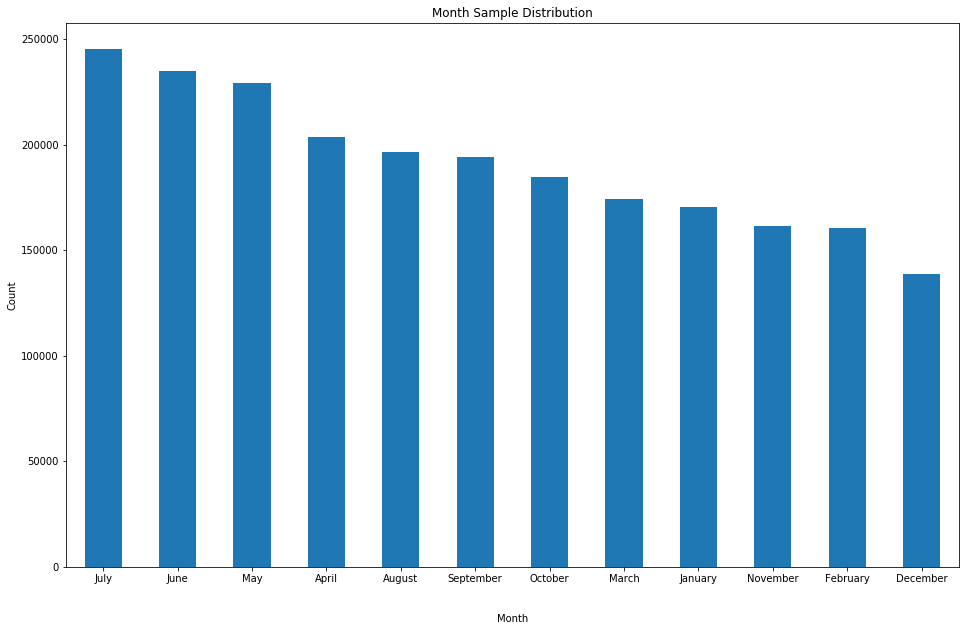

In [39]:
# how many shares per hour in total?
axes = df['month'].value_counts().plot(kind='bar', figsize=fig_size)
axes.set_xlabel('Weekday', labelpad=30)
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Month Sample Distribution')

## Weather data

In [40]:
from configs import weather_data_csv
import json
holidays = 'holidays.csv'
hol_df = pd.read_csv(holidays, index_col='date', parse_dates=['date'])
weather_df = pd.read_csv(weather_data_csv, index_col='timestamp', parse_dates=['timestamp'])
weather_df.head()

,temperature,feelsLike,wind,weatherCode
timestamp,,,,
2015-01-01 00:00:00,3,-2,21,116
2015-01-01 01:00:00,3,-2,21,116
2015-01-01 02:00:00,3,-1,20,116
2015-01-01 03:00:00,3,-1,20,116
2015-01-01 04:00:00,4,0,20,116


In [41]:
# check if the start date hits on a holiday
hol_set= set(hol_df.index.map(lambda x: x.date()))
df['is_holiday'] = df['Start Date'].map(lambda x: x.date() in hol_set).map(lambda x: '1' if x else '0')

# check if start date hits on a weekend
# monday is 0, sunday is 6
df['is_weekend'] = df['Start Date'].map(lambda x: x.weekday() > 4).map(lambda x: '1' if x else '0')

In [42]:
from datetime import datetime
date_mapper = lambda x: pd.to_datetime(datetime(year=x.year, month=x.month, day=x.day, hour=x.hour))
df['Start Date'] = df['Start Date'].map(date_mapper)

In [45]:
share_df = df.groupby('Start Date').agg({'Start Date': 'count'}).rename(columns={'Start Date': 'share_count'})

share_df = share_df.join(weather_df)
share_df = share_df.reset_index()
# drop rows with missing data (weather data)
# aparently the join function does not find indexes???
print('Old size:', len(share_df))
share_df = share_df.dropna()
print('New size:', len(share_df))
share_df.head()

Old size: 39608
New size: 38033


,Start Date,share_count,temperature,feelsLike,wind,weatherCode
0,2015-01-02 00:00:00,14,10.0,7.0,35.0,122.0
1,2015-01-02 01:00:00,18,11.0,7.0,34.0,122.0
2,2015-01-02 02:00:00,11,11.0,8.0,32.0,122.0
3,2015-01-02 03:00:00,5,11.0,8.0,31.0,122.0
4,2015-01-02 04:00:00,2,11.0,8.0,26.0,122.0


In [46]:
share_df['month'] = share_df['Start Date'].apply(lambda t: t.month)
share_df['weekday'] = share_df['Start Date'].apply(lambda t: t.weekday())
share_df['hour'] = share_df['Start Date'].apply(lambda t: t.hour)
share_df['is_holiday'] = share_df['Start Date'].map(lambda x: x.date() in hol_set).map(lambda x: '1' if x else '0')
# check if start date hits on a weekend
# monday is 0, sunday is 6
share_df['is_weekend'] = share_df['Start Date'].map(lambda x: x.weekday() > 4).map(lambda x: '1' if x else '0')
share_df['weatherCode'] = share_df['weatherCode'].map(lambda x: str(int(x)))
print(share_df.dtypes)
share_df.head()

Start Date     datetime64[ns]
share_count             int64
temperature           float64
feelsLike             float64
wind                  float64
weatherCode            object
month                   int64
weekday                 int64
hour                    int64
is_holiday             object
is_weekend             object
dtype: object


,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2015-01-02 00:00:00,14,10.0,7.0,35.0,122,1,4,0,0,0
1,2015-01-02 01:00:00,18,11.0,7.0,34.0,122,1,4,1,0,0
2,2015-01-02 02:00:00,11,11.0,8.0,32.0,122,1,4,2,0,0
3,2015-01-02 03:00:00,5,11.0,8.0,31.0,122,1,4,3,0,0
4,2015-01-02 04:00:00,2,11.0,8.0,26.0,122,1,4,4,0,0


Below we can see again that we have bigger share values at 8 o'clock and 17 o'clock.
However, during weekends and holidays, those values are lower and we see higher share values over the afternoon.

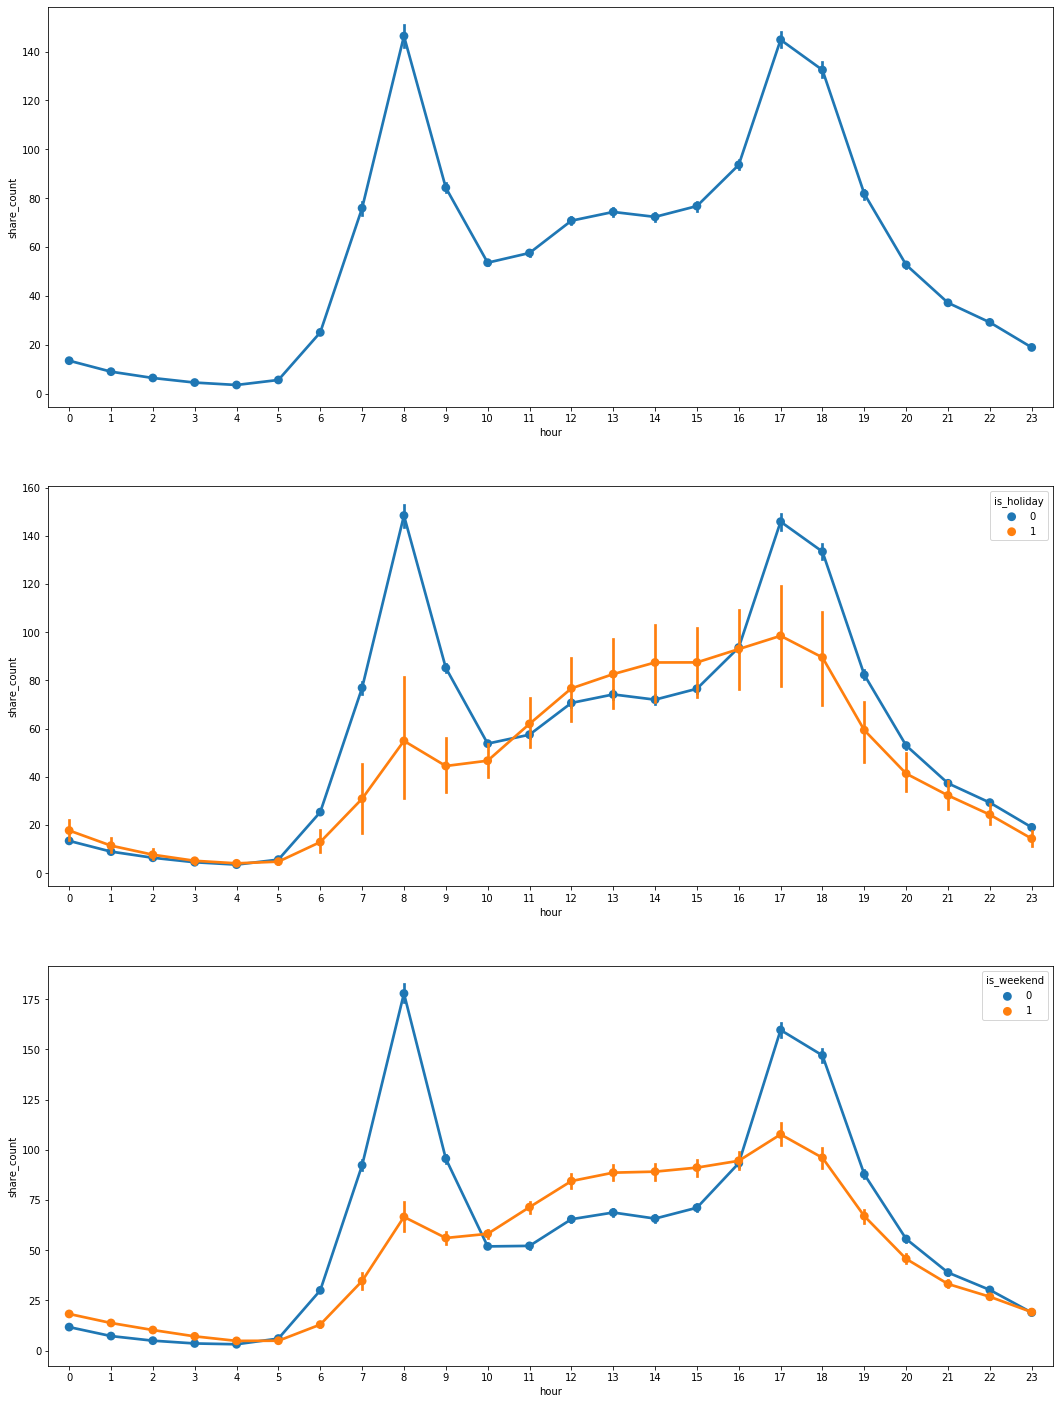

In [49]:
# fig,(ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18,25)
data = share_df
sns.pointplot(data=data, x='hour', y='share_count', ax=ax1)
sns.pointplot(data=data, x='hour', y='share_count', hue='is_holiday', ax=ax2)
sns.pointplot(data=data, x='hour', y='share_count', hue='is_weekend', ax=ax3)
# sns.pointplot(data=data, x='hour', y='share_count', hue='temperature', ax=ax4) # this line breaks the graphs
# sns.pointplot(data=data, x='hour', y='share_count', hue='weatherCode', ax=ax5) # this line breaks the graphs

In [51]:
for_model = share_df.drop(axis=1, labels=['Start Date'])
for_model.head()

,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,14,10.0,7.0,35.0,122,1,4,0,0,0
1,18,11.0,7.0,34.0,122,1,4,1,0,0
2,11,11.0,8.0,32.0,122,1,4,2,0,0
3,5,11.0,8.0,31.0,122,1,4,3,0,0
4,2,11.0,8.0,26.0,122,1,4,4,0,0


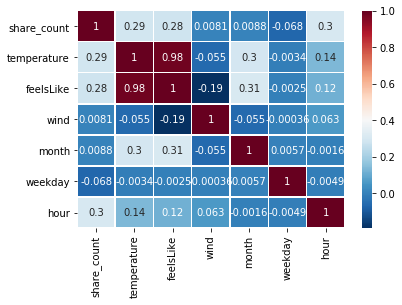

In [60]:
pearsoncorr = for_model.corr(method='pearson')
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [52]:
train_set, test_set = train_test_split(for_model, test_size=0.2, random_state=rnd_seed)
X_train = train_set.drop(axis=1, labels=['share_count']).to_numpy()
Y_train = train_set['share_count'].to_numpy()

X_test = test_set.drop(axis=1, labels=['share_count']).to_numpy()
Y_test = test_set['share_count'].to_numpy()

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [54]:
classifiers = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=100)),
#     ('NN (100, 100)', MLPClassifier(hidden_layer_sizes=(100, 100))),
#     ('NN (50)', MLPClassifier(hidden_layer_sizes=(50))),
    ('NN (16, 16, 16)', MLPClassifier(hidden_layer_sizes=(16, 16, 16)))
]
classifiers = [] # don't do anything for now

In [55]:
import time
for name, clf in classifiers:
    print(f'** {name}')
    t0 = time.time()
    clf.fit(X_train, Y_train)
    t1 = time.time()
    score_train = clf.score(X_train[:10000], Y_train[:10000])
    t2 = time.time()
    score_test = clf.score(X_test, Y_test)
    t3 = time.time()
    print(f'\tTraining time {t1 - t0:3.3f}')
    print(f'\tPrediction time (train) {t2 - t1:3.3f}')
    print(f'\tPrediction time (test) {t3 - t2:3.3f}')
    print(f'\tScore train: {score_train:.3f}\tScore Test: {score_test:.3f}')